In [ ]:
# Install required packages
!pip install wfdb numpy pandas scipy scikit-learn tensorflow matplotlib

In [ ]:
import os
import numpy as np
import pandas as pd
import wfdb
from scipy.signal import butter, lfilter
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (Conv1D, MaxPool1D, Flatten, Dense, Input,
                                    LSTM, Bidirectional, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import sklearn

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def bandpass_filter(data, lowcut=0.001, highcut=15.0, signal_freq=360, filter_order=1):
    """Apply bandpass filter to ECG signal"""
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    y = lfilter(b, a, data)
    return y

def load_challenge_data(filename):
    """Load ECG data and header information"""
    try:
        print(f"Attempting to load: {filename}")
        base_name = os.path.splitext(filename)[0]
        record = wfdb.rdsamp(base_name, return_res=16)
        if isinstance(record, tuple):
            data = np.asarray(record[0], dtype=np.float64)
            print(f"Loaded tuple data from {filename}, shape: {data.shape}")
        else:
            data = np.asarray(record.p_signal, dtype=np.float64)
            print(f"Loaded record data from {filename}, shape: {data.shape}")
        if data.ndim == 2 and data.shape[1] == 2:
            data = data.T
            print(f"Transposed data to: {data.shape}")
        elif data.ndim == 2 and data.shape[0] != 2:
            raise ValueError(f"Expected 2 leads, got shape {data.shape}")
        elif data.ndim == 1:
            print(f"Warning: Data is 1D with shape {data.shape}, attempting to reshape for 2 leads")
            if data.shape[0] % 2 != 0:
                raise ValueError(f"Cannot reshape 1D data of length {data.shape[0]} into 2 leads")
            num_samples = data.shape[0] // 2
            data = data.reshape(2, num_samples)
            print(f"Reshaped data to: {data.shape}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        raise

    # Load header file
    header_file = filename.replace('.dat', '.hea')
    try:
        with open(header_file, 'r') as f:
            header_data = f.readlines()
        print(f"Loaded header from {header_file}")
    except Exception as e:
        print(f"Error loading header {header_file}: {e}")
        raise

    return data, header_data

def get_classes(input_directory, files):
    """Define the classes we're interested in"""
    classes = ['N', 'L', 'R', 'A', 'S', 'V']  # Normal and 5 arrhythmia types
    return sorted(classes)

def get_true_labels(input_file, classes):
    """Extract labels from annotation files"""
    atr_file = input_file.replace('.hea', '.atr')
    try:
        annotation = wfdb.rdann(input_file.replace('.hea', ''), 'atr')
        symbols = annotation.symbol
        print(f"Annotations for {atr_file}: {set(symbols)}")

        # Count occurrences of each class in annotations
        label_counts = {c: symbols.count(c) for c in classes}
        print(f"Label counts: {label_counts}")

        if not any(label_counts.values()):
            print(f"No matching annotations found in {atr_file}")
            return None, classes, np.zeros(len(classes), dtype=int)

        # Get the dominant label (most frequent)
        dominant_label = max(label_counts, key=label_counts.get)
        single_recording_labels = np.zeros(len(classes), dtype=int)

        if dominant_label in classes:
            idx = classes.index(dominant_label)
            single_recording_labels[idx] = 1

        print(f"Dominant label for {atr_file}: {dominant_label}")
        return dominant_label, classes, single_recording_labels
    except Exception as e:
        print(f"Error reading annotations from {atr_file}: {e}")
        return None, classes, np.zeros(len(classes), dtype=int)

def extend_ts(ts, length):
    """Extend or truncate time series to specified length"""
    extended = np.zeros(length)
    siglength = np.min([length, ts.shape[0]])
    extended[:siglength] = ts[:siglength]
    return extended

def compute_beta_score(labels, output, beta, num_classes, check_errors=True):
    """Compute beta score for evaluation"""
    if check_errors:
        if len(output) != len(labels):
            raise Exception('Numbers of outputs and labels must be the same.')

    num_recordings = len(labels)
    fbeta_l = np.zeros(num_classes)
    gbeta_l = np.zeros(num_classes)
    fmeasure_l = np.zeros(num_classes)
    accuracy_l = np.zeros(num_classes)

    f_beta = g_beta = f_measure = accuracy = 0
    C_l = np.ones(num_classes)

    for j in range(num_classes):
        tp = fp = fn = tn = 0
        for i in range(num_recordings):
            num_labels = np.sum(labels[i])
            if num_labels == 0:
                continue
            if labels[i][j] and output[i][j]:
                tp += 1 / num_labels
            elif not labels[i][j] and output[i][j]:
                fp += 1 / num_labels
            elif labels[i][j] and not output[i][j]:
                fn += 1 / num_labels
            elif not labels[i][j] and not output[i][j]:
                tn += 1 / num_labels

        if ((1 + beta**2) * tp + (fn * beta**2) + fp):
            fbeta_l[j] = float((1 + beta**2) * tp) / float(((1 + beta**2) * tp) + (fn * beta**2) + fp)
        else:
            fbeta_l[j] = 1.0

        if (tp + fp + beta * fn):
            gbeta_l[j] = float(tp) / float(tp + fp + beta * fn)
        else:
            gbeta_l[j] = 1.0

        if tp + fp + fn + tn:
            accuracy_l[j] = float(tp + tn) / float(tp + fp + fn + tn)
        else:
            accuracy_l[j] = 1.0

        if 2 * tp + fp + fn:
            fmeasure_l[j] = float(2 * tp) / float(2 * tp + fp + fn)
        else:
            fmeasure_l[j] = 1.0

    for i in range(num_classes):
        f_beta += fbeta_l[i] * C_l[i]
        g_beta += gbeta_l[i] * C_l[i]
        f_measure += fmeasure_l[i] * C_l[i]
        accuracy += accuracy_l[i] * C_l[i]

    f_beta = float(f_beta) / float(num_classes)
    g_beta = float(g_beta) / float(num_classes)
    f_measure = float(f_measure) / float(num_classes)
    accuracy = float(accuracy) / float(num_classes)

    return accuracy, f_measure, f_beta, g_beta

# Download the MIT-BIH dataset
!wget https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip mit-bih-arrhythmia-database-1.0.0.zip

# Parameters
input_directory = './mit-bih-arrhythmia-database-1.0.0'
num_leads = 2  # MLII and V5 leads
fs = 360  # Sampling frequency (Hz)
frame_len = 15000  # 41.67 seconds at 360 Hz
num_folds = 5  # For cross-validation
batch_size = 32
epochs = 20  # Increased from the original for better training

# Get list of files
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('.dat'):
        input_files.append(f)
print("Found files:", input_files)

if not input_files:
    raise ValueError(f"No .dat files found in {input_directory}")

# Verify all required files exist
for f in input_files:
    dat_path = os.path.join(input_directory, f)
    hea_path = dat_path.replace('.dat', '.hea')
    atr_path = dat_path.replace('.dat', '.atr')
    print(f"Checking {f}: .dat={'Exists' if os.path.exists(dat_path) else 'Missing'}, "
          f".hea={'Exists' if os.path.exists(hea_path) else 'Missing'}, "
          f".atr={'Exists' if os.path.exists(atr_path) else 'Missing'}")

# Get classes and initialize data structures
classes = get_classes(input_directory, input_files)
print("Classes:", classes)
num_classes = len(classes)
if num_classes == 0:
    raise ValueError("No classes found. Check .atr files for annotations.")

num_files = len(input_files)
X = np.zeros((num_files, frame_len, num_leads), dtype=np.float32)
multi_labels = np.zeros((num_files, len(classes)), dtype=int)
y = np.zeros((num_files), dtype=int)
valid_files = 0

# Load and preprocess data
for i, f in enumerate(input_files):
    print(f'Processing {i + 1}/{num_files}...')
    tmp_input_file = os.path.join(input_directory, f)
    hea_file = tmp_input_file.replace('.dat', '.hea')

    if not os.path.exists(hea_file):
        print(f"Warning: .hea file not found for {f}: {hea_file}")
        continue

    try:
        data, header_data = load_challenge_data(tmp_input_file)
    except Exception as e:
        print(f"Skipping {f} due to error: {e}")
        continue

    if data.shape[0] != num_leads:
        print(f"Warning: Expected {num_leads} leads, got {data.shape[0]} for {f}")
        continue

    # Truncate if longer than frame_len
    if data.shape[1] > frame_len:
        data = data[:, :frame_len]

    # Preprocess each lead
    extended_data = np.zeros((num_leads, frame_len))
    for j in range(num_leads):
        if data[j, :].any():
            # Normalize (zero mean, unit variance)
            data[j, :] = (data[j, :] - np.expand_dims(data[j, :].mean(0), 0)) / np.expand_dims(data[j, :].std(0), 0)
        # Apply bandpass filter and extend/truncate
        extended_data[j, :] = bandpass_filter(extend_ts(data[j, :], length=frame_len))

    X[i, :, :] = extended_data.T

    # Get labels
    g = f.replace('.dat', '.hea')
    tmp_input_file = os.path.join(input_directory, g)
    recording_label, classes_label, multi_labels[i] = get_true_labels(tmp_input_file, classes)
    idx = np.where(multi_labels[i] == 1)

    if len(idx[0]) == 0:
        print(f"Warning: No valid label found for {f}")
        continue

    y[i] = idx[0][0]
    valid_files += 1

print("Labels (y):", y)
print(f"Unique labels: {np.unique(y)}")
print(f"Valid files processed: {valid_files}")

if valid_files == 0:
    raise ValueError("No valid files with labels extracted. Check .atr files or label extraction logic.")

# Trim arrays to only valid files
X = X[:valid_files]
multi_labels = multi_labels[:valid_files]
y = y[:valid_files]

# One-hot encode labels
try:
    onehot_encoder = OneHotEncoder(sparse_output=False, categories=[np.arange(num_classes)])
except TypeError:
    onehot_encoder = OneHotEncoder(sparse=False, categories=[np.arange(num_classes)])
y_ = onehot_encoder.fit_transform(y.reshape(-1, 1))
print(f"One-hot encoded labels shape: {y_.shape}")
print('Preprocessing complete.')

--2025-06-11 21:00:13--  https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77030320 (73M) [application/zip]
Saving to: ‘mit-bih-arrhythmia-database-1.0.0.zip.3’

mit-bih-arrhythmia- 100%[===================>]  73.46M   280KB/s    in 4m 40s  

2025-06-11 21:04:53 (269 KB/s) - ‘mit-bih-arrhythmia-database-1.0.0.zip.3’ saved [77030320/77030320]

Archive:  mit-bih-arrhythmia-database-1.0.0.zip
replace mit-bih-arrhythmia-database-1.0.0/100.atr? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mit-bih-arrhythmia-database-1.0.0/100.atr  
replace mit-bih-arrhythmia-database-1.0.0/100.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: Found files: ['118.dat', '213.dat', '201.dat', '109.dat', '112.dat', '234.dat', '223.dat', '100.dat', '119.dat', '232.dat',

--------------------------------------------------------------------------------
Training CNN for fold 1...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0263 - loss: 0.1731      
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to cnn_model_fold_1.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.0351 - loss: 0.1727 - val_accuracy: 0.9000 - val_loss: 0.1370
Epoch 2/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7812 - loss: 0.1419
Epoch 2: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7692 - loss: 0.1391 - val_accuracy: 0.9000 - val_loss: 0.0464
Epoch 3/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7812 - loss: 0.0803
Epoch 3: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7692 - loss: 0.0819 - val_accuracy: 0.9000 - val_loss: 0.0597
Epoch 4/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7812 - loss: 0.0694
Epoch 4: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7692 - loss: 0.0709 - val_accuracy: 0.9000 - val_loss: 0.0698
Epoch 5/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7812 - loss: 0.0702
Epoch 5: val_accuracy did not improve from 0.90000
2/

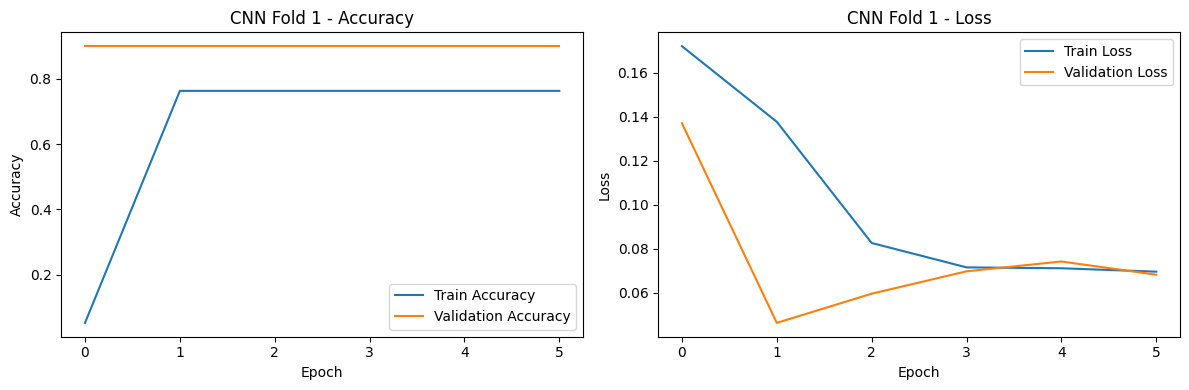

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
Confusion Matrix (Fold 1):
[[9 0]
 [1 0]]
Fold 1 Metrics:
Accuracy: 0.9667
F1 Score: 0.8246
F_beta Score: 0.8297
G_beta Score: 0.8167
--------------------------------------------------------------------------------
Training CNN for fold 2...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8273 - loss: 0.1591
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to cnn_model_fold_2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8322 - loss: 0.1577 - val_accuracy: 0.5000 - val_loss: 0.1708
Epoch 2/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8438 - loss: 0.0737
Epoch 2: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8602 - loss: 0.0664 - val_accuracy: 0.5000 - val_loss: 0.1634
Epoch 3/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8438 - loss: 0.0498
Epoch 3: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8602 - loss: 0.0465 - val_accuracy: 0.5000 - val_loss: 0.1411
Epoch 4/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8438 - loss: 0.0450
Epoch 4: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8602 - loss: 0.0413 - val_accuracy: 0.5000 - val_loss: 0.1593
Epoch 5/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8438 - loss: 0.0431
Epoch 5: val_accuracy did not improve from 0.50000
2/2

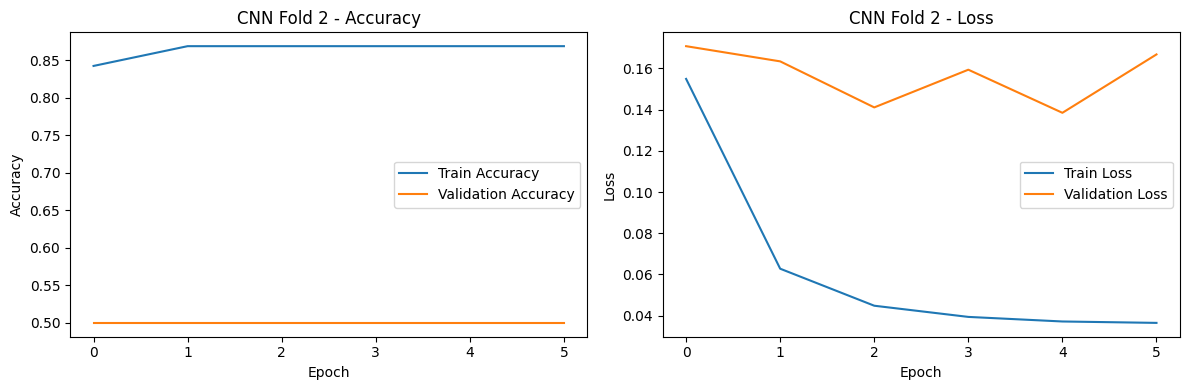

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Confusion Matrix (Fold 2):
[[0 0 1 0]
 [0 0 3 0]
 [0 0 5 0]
 [0 0 1 0]]
Fold 2 Metrics:
Accuracy: 0.8333
F1 Score: 0.4444
F_beta Score: 0.4722
G_beta Score: 0.4167
--------------------------------------------------------------------------------
Training CNN for fold 3...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0946 - loss: 0.1719
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to cnn_model_fold_3.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.1157 - loss: 0.1716 - val_accuracy: 0.9000 - val_loss: 0.1377
Epoch 2/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.1394
Epoch 2: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7588 - loss: 0.1347 - val_accuracy: 0.9000 - val_loss: 0.1270
Epoch 3/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7500 - loss: 0.1786
Epoch 3: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7588 - loss: 0.1672 - val_accuracy: 0.9000 - val_loss: 0.0788
Epoch 4/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7500 - loss: 0.0910
Epoch 4: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7588 - loss: 0.0912 - val_accuracy: 0.9000 - val_loss: 0.1000
Epoch 5/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7500 - loss: 0.1072
Epoch 5: val_accuracy did not improve from 0.90000
2/2 ━

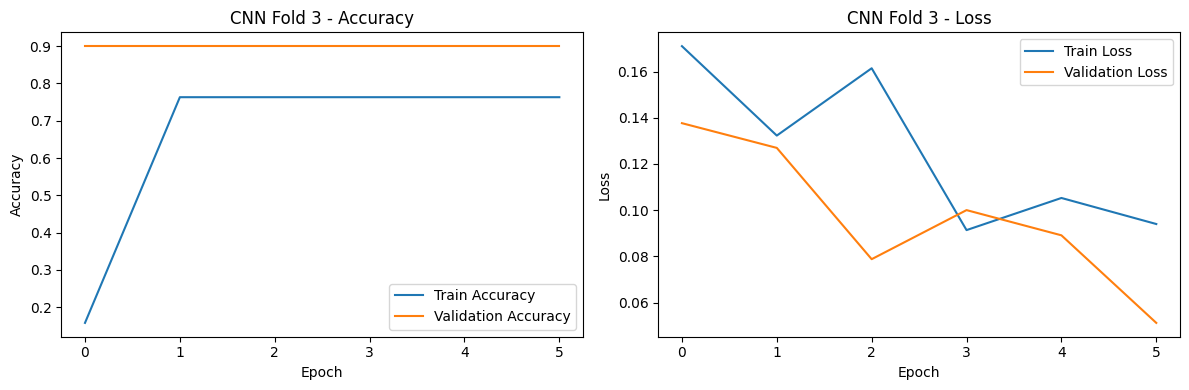

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
Confusion Matrix (Fold 3):
[[9 0]
 [1 0]]
Fold 3 Metrics:
Accuracy: 0.9667
F1 Score: 0.8246
F_beta Score: 0.8297
G_beta Score: 0.8167
--------------------------------------------------------------------------------
Training CNN for fold 4...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0000e+00 - loss: 0.1682
Epoch 1: val_accuracy improved from -inf to 0.11111, saving model to cnn_model_fold_4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.0000e+00 - loss: 0.1682 - val_accuracy: 0.1111 - val_loss: 0.1560
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1651 - loss: 0.1543 
Epoch 2: val_accuracy improved from 0.11111 to 0.77778, saving model to cnn_model_fold_4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.1784 - loss: 0.1539 - val_accuracy: 0.7778 - val_loss: 0.1004
Epoch 3/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8125 - loss: 0.1015
Epoch 3: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.8007 - loss: 0.1062 - val_accuracy: 0.7778 - val_loss: 0.0796
Epoch 4/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8125 - loss: 0.0691
Epoch 4: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8007 - loss: 0.0705 - val_accuracy: 0.7778 - val_loss: 0.0992
Epoch 5/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8125 - loss: 0.0816
Epoch 5: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8007 - loss: 0.0817 - val_accuracy: 0.7778 - val_loss: 0.0924
Epoch 6/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8125 - loss: 0.0720
Epoch 6: val_accuracy did not improve from 0.77778
2/

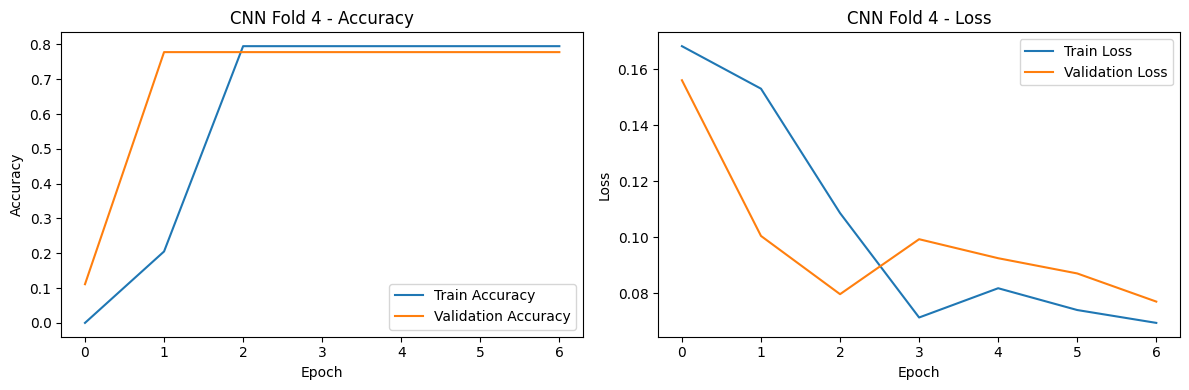

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
Confusion Matrix (Fold 4):
[[7 0]
 [2 0]]
Fold 4 Metrics:
Accuracy: 0.9259
F1 Score: 0.8125
F_beta Score: 0.8243
G_beta Score: 0.7963
--------------------------------------------------------------------------------
Training CNN for fold 5...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1366 - loss: 0.1703
Epoch 1: val_accuracy improved from -inf to 0.88889, saving model to cnn_model_fold_5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.1509 - loss: 0.1699 - val_accuracy: 0.8889 - val_loss: 0.1212
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7752 - loss: 0.1226 
Epoch 2: val_accuracy did not improve from 0.88889
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7732 - loss: 0.1214 - val_accuracy: 0.8889 - val_loss: 0.0867
Epoch 3/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7812 - loss: 0.1392
Epoch 3: val_accuracy did not improve from 0.88889
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7732 - loss: 0.1312 - val_accuracy: 0.8889 - val_loss: 0.0743
Epoch 4/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7812 - loss: 0.0872
Epoch 4: val_accuracy did not improve from 0.88889
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7732 - loss: 0.0889 - val_accuracy: 0.8889 - val_loss: 0.0991
Epoch 5/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7812 - loss: 0.1088
Epoch 5: val_accuracy did not improve from 0.88889
2/2 ━

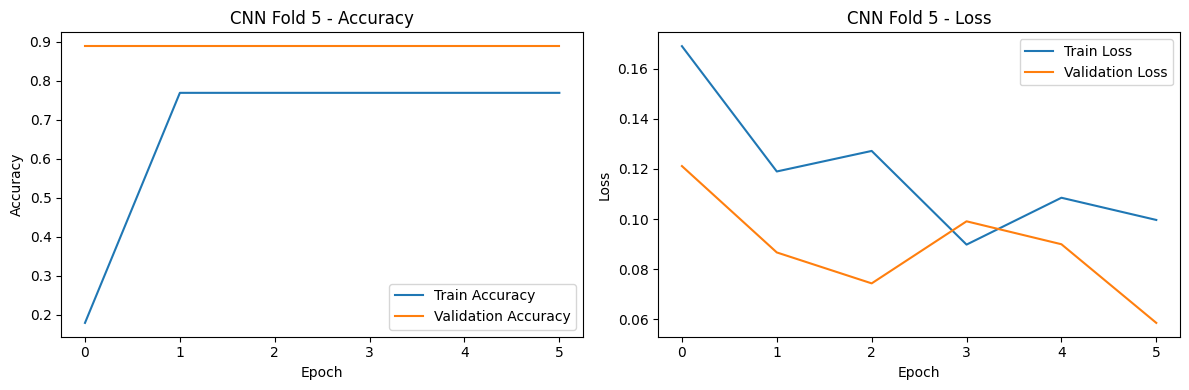

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Confusion Matrix (Fold 5):
[[0 1]
 [0 8]]
Fold 5 Metrics:
Accuracy: 0.9630
F1 Score: 0.8235
F_beta Score: 0.8293
G_beta Score: 0.8148

CNN Performance Summary:
      Accuracy        F1    F_beta    G_beta
0     0.966667  0.824561  0.829710  0.816667
1     0.833333  0.444444  0.472222  0.416667
2     0.966667  0.824561  0.829710  0.816667
3     0.925926  0.812500  0.824324  0.796296
4     0.962963  0.823529  0.829268  0.814815
Mean  0.931111  0.745919  0.757047  0.732222
Std   0.051245  0.150806  0.142427  0.157965


In [ ]:
def create_cnn_model(frame_len, num_classes):
    """Create the CNN model architecture"""
    model = Sequential([
        Input(shape=(frame_len, num_leads)),
        tf.keras.layers.GaussianNoise(0.1),  # Add noise for regularization
        Conv1D(64, 15, activation='relu'),
        MaxPool1D(2),
        Conv1D(64, 15, activation='relu'),
        MaxPool1D(2),
        Conv1D(64, 15, activation='relu'),
        MaxPool1D(2),
        Conv1D(64, 9, activation='relu'),
        MaxPool1D(3),
        Conv1D(64, 9, activation='relu'),
        MaxPool1D(3),
        Conv1D(32, 9, activation='relu'),
        MaxPool1D(3),
        Conv1D(32, 3, activation='relu'),
        MaxPool1D(4),
        Flatten(),
        Dense(64, kernel_initializer='normal', activation='relu'),
        Dense(num_classes, kernel_initializer='normal')
    ])

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

# Prepare for cross-validation
stats_cnn = np.zeros((num_folds, 4))
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Train and evaluate CNN
fold_no = 1
for train_idx, test_idx in kfold.split(X, y_):
    print('-' * 80)
    print(f'Training CNN for fold {fold_no}...')

    # Create and compile model
    model = create_cnn_model(frame_len, num_classes)

    # Create callbacks
    model_path = f'cnn_model_fold_{fold_no}.h5'
    callbacks = [
        ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1,
                       save_best_only=True, mode='max'),
        EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
    ]

    # Train model
    history = model.fit(
        X[train_idx], y_[train_idx],
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X[test_idx], y_[test_idx]),
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'CNN Fold {fold_no} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'CNN Fold {fold_no} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'cnn_accuracy_loss_fold{fold_no}.png')
    plt.show()

    # Load best model
    model.load_weights(model_path)

    # Evaluate on test set
    y_test_pred = model.predict(X[test_idx])
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    y_test_true_classes = np.argmax(y_[test_idx], axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
    print(f"Confusion Matrix (Fold {fold_no}):\n{cm}")

    # Compute metrics
    output = np.argmax(y_test_pred, 1)
    output_ = onehot_encoder.transform(output.reshape(-1, 1))

    accuracy, f_measure, Fbeta_measure, Gbeta_measure = compute_beta_score(
        multi_labels[test_idx], output_, 2, num_classes, check_errors=True)

    stats_cnn[fold_no - 1] = [accuracy, f_measure, Fbeta_measure, Gbeta_measure]

    print(f"Fold {fold_no} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f_measure:.4f}")
    print(f"F_beta Score: {Fbeta_measure:.4f}")
    print(f"G_beta Score: {Gbeta_measure:.4f}")

    fold_no += 1

# Save CNN results
cnn_results = pd.DataFrame(stats_cnn, columns=["Accuracy", "F1", "F_beta", "G_beta"])
cnn_results.loc['Mean'] = cnn_results.mean()
cnn_results.loc['Std'] = cnn_results.std()
print("\nCNN Performance Summary:")
print(cnn_results)
cnn_results.to_csv('cnn_performance.csv')

Training LSTM Configuration 1: {'units': 64, 'layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001}
--------------------------------------------------------------------------------
Training LSTM Config 1 - Fold 1...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.2541 - loss: 1.8969
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to lstm_config1_fold1.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2659 - loss: 1.8822 - val_accuracy: 0.7000 - val_loss: 1.6970
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.4424 - loss: 1.7190
Epoch 2: val_accuracy improved from 0.70000 to 0.80000, saving model to lstm_config1_fold1.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step - accuracy: 0.4441 - loss: 1.7107 - val_accuracy: 0.8000 - val_loss: 1.6633
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.5732 - loss: 1.4829
Epoch 3: val_accuracy did not improve from 0.80000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step - accuracy: 0.5663 - loss: 1.4794 - val_accuracy: 0.8000 - val_loss: 1.6325
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5551 - loss: 1.4037
Epoch 4: val_accuracy did not improve from 0.80000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step - accuracy: 0.5630 - loss: 1.3843 - val_accuracy: 0.8000 - val_loss: 1.6033
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6414 - loss: 1.3991
Epoch 5: val_accuracy improved from 0.80000 to 0.90000, saving model to lstm_config1_fold1.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step - accuracy: 0.6469 - loss: 1.3870 - val_accuracy: 0.9000 - val_loss: 1.5749
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6990 - loss: 1.2795
Epoch 6: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step - accuracy: 0.7029 - loss: 1.2775 - val_accuracy: 0.9000 - val_loss: 1.5477
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7566 - loss: 1.1136
Epoch 7: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - accuracy: 0.7588 - loss: 1.0994 - val_accuracy: 0.9000 - val_loss: 1.5229
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7697 - loss: 1.1618
Epoch 8: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step - accuracy: 0.7763 - loss: 1.1433 - val_accuracy: 0.9000 - val_loss: 1.4990
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7697 - loss: 1.0939
Epoch 9: val_accuracy did not improve from 0.90000


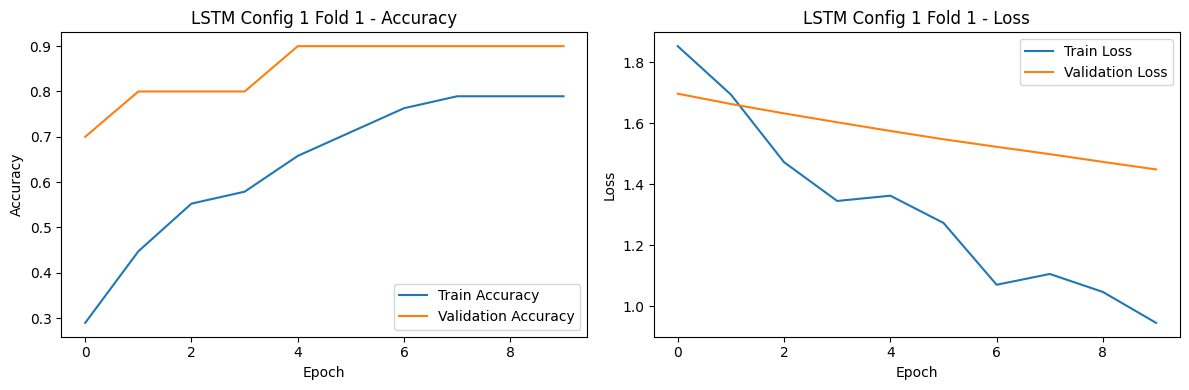

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Confusion Matrix (Config 1, Fold 1):
[[9 0]
 [1 0]]
Config 1 - Fold 1 Metrics:
Accuracy: 0.9667
F1 Score: 0.8246
F_beta Score: 0.8297
G_beta Score: 0.8167
--------------------------------------------------------------------------------
Training LSTM Config 1 - Fold 2...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.2122 - loss: 1.7363
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to lstm_config1_fold2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 824ms/step - accuracy: 0.2204 - loss: 1.7197 - val_accuracy: 0.4000 - val_loss: 1.8113
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3692 - loss: 1.6825
Epoch 2: val_accuracy did not improve from 0.40000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 652ms/step - accuracy: 0.3777 - loss: 1.6633 - val_accuracy: 0.4000 - val_loss: 1.7884
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.5000 - loss: 1.4663
Epoch 3: val_accuracy improved from 0.40000 to 0.50000, saving model to lstm_config1_fold2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step - accuracy: 0.5000 - loss: 1.4491 - val_accuracy: 0.5000 - val_loss: 1.7681
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.6414 - loss: 1.1135
Epoch 4: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - accuracy: 0.6469 - loss: 1.1048 - val_accuracy: 0.5000 - val_loss: 1.7510
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7122 - loss: 1.1383
Epoch 5: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - accuracy: 0.7204 - loss: 1.1227 - val_accuracy: 0.5000 - val_loss: 1.7369
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.7985 - loss: 1.0033
Epoch 6: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step - accuracy: 0.8043 - loss: 0.9857 - val_accuracy: 0.5000 - val_loss: 1.7252
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.7697 - loss: 1.0190
Epoch 7: val_accuracy did not improve from 0.50000


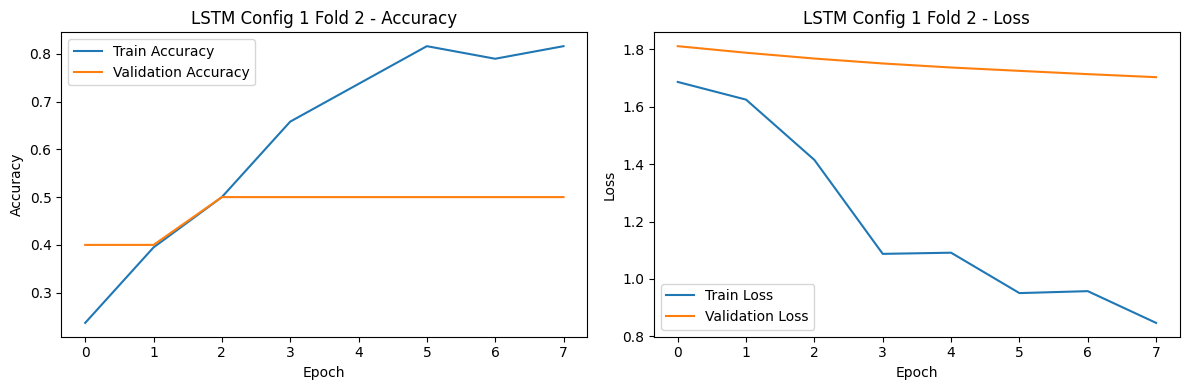

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
Confusion Matrix (Config 1, Fold 2):
[[0 0 1 0]
 [0 0 3 0]
 [0 0 5 0]
 [0 0 1 0]]
Config 1 - Fold 2 Metrics:
Accuracy: 0.8333
F1 Score: 0.4444
F_beta Score: 0.4722
G_beta Score: 0.4167
--------------------------------------------------------------------------------
Training LSTM Config 1 - Fold 3...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.1414 - loss: 2.6207
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to lstm_config1_fold3.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 975ms/step - accuracy: 0.1469 - loss: 2.6185 - val_accuracy: 0.2000 - val_loss: 1.7864
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.1283 - loss: 2.3055
Epoch 2: val_accuracy improved from 0.20000 to 0.70000, saving model to lstm_config1_fold3.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.1294 - loss: 2.2998 - val_accuracy: 0.7000 - val_loss: 1.7434
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.2122 - loss: 2.1673
Epoch 3: val_accuracy improved from 0.70000 to 0.90000, saving model to lstm_config1_fold3.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - accuracy: 0.2204 - loss: 2.1589 - val_accuracy: 0.9000 - val_loss: 1.7039
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3248 - loss: 1.6775
Epoch 4: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 492ms/step - accuracy: 0.3394 - loss: 1.6729 - val_accuracy: 0.9000 - val_loss: 1.6659
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3824 - loss: 1.6217
Epoch 5: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - accuracy: 0.3953 - loss: 1.6122 - val_accuracy: 0.9000 - val_loss: 1.6310
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.4844 - loss: 1.5309
Epoch 6: val_accuracy did not improve from 0.90000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step - accuracy: 0.4896 - loss: 1.5227 - val_accuracy: 0.9000 - val_loss: 1.5952
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.3824 - loss: 1.4356
Epoch 7: val_accuracy did not improve from 0.90000


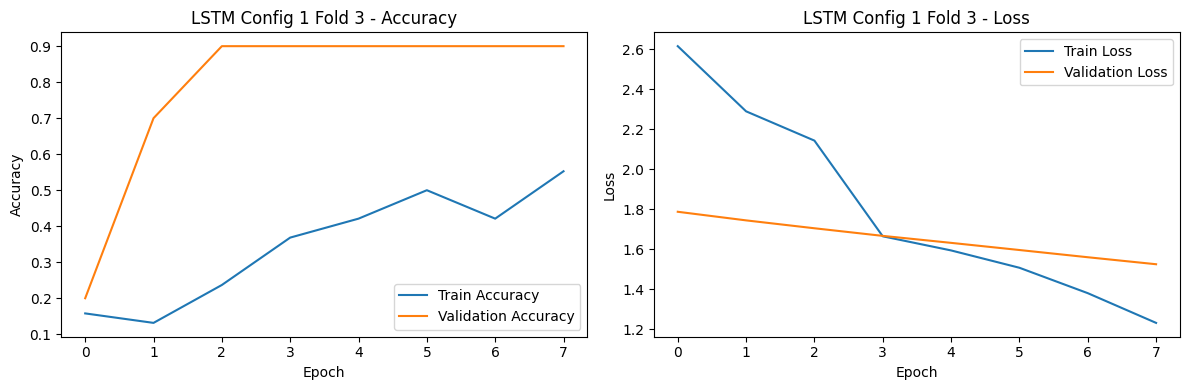

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Confusion Matrix (Config 1, Fold 3):
[[9 0]
 [1 0]]
Config 1 - Fold 3 Metrics:
Accuracy: 0.9667
F1 Score: 0.8246
F_beta Score: 0.8297
G_beta Score: 0.8167
--------------------------------------------------------------------------------
Training LSTM Config 1 - Fold 4...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.2817 - loss: 1.9117
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to lstm_config1_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 822ms/step - accuracy: 0.2818 - loss: 1.9070 - val_accuracy: 0.3333 - val_loss: 1.7488
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.4808 - loss: 1.6705
Epoch 2: val_accuracy improved from 0.33333 to 0.55556, saving model to lstm_config1_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 689ms/step - accuracy: 0.4744 - loss: 1.6714 - val_accuracy: 0.5556 - val_loss: 1.7210
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.3954 - loss: 1.6470
Epoch 3: val_accuracy improved from 0.55556 to 0.77778, saving model to lstm_config1_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - accuracy: 0.3918 - loss: 1.6455 - val_accuracy: 0.7778 - val_loss: 1.6986
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.4936 - loss: 1.4159
Epoch 4: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - accuracy: 0.4915 - loss: 1.4233 - val_accuracy: 0.7778 - val_loss: 1.6775
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.5505 - loss: 1.3052
Epoch 5: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - accuracy: 0.5465 - loss: 1.3071 - val_accuracy: 0.7778 - val_loss: 1.6576
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6643 - loss: 1.2234
Epoch 6: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 690ms/step - accuracy: 0.6565 - loss: 1.2268 - val_accuracy: 0.7778 - val_loss: 1.6391
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6046 - loss: 1.2541
Epoch 7: val_accuracy did not improve from 0.77778


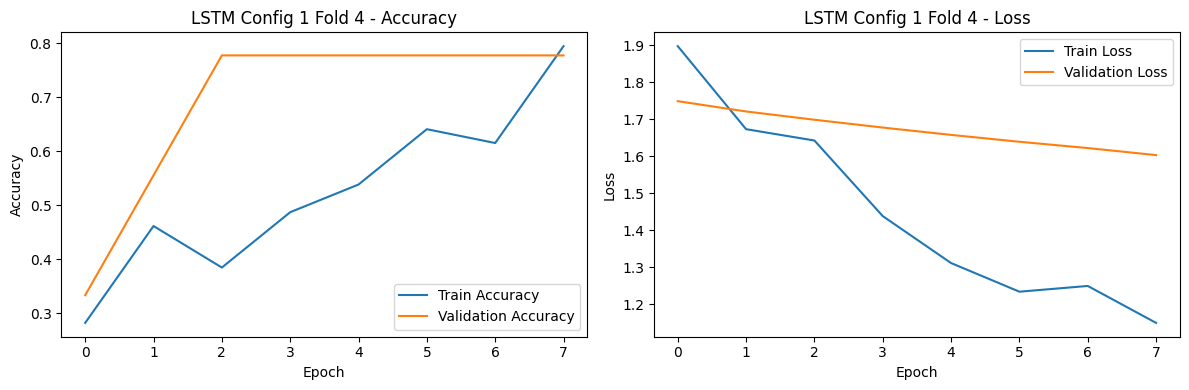

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Confusion Matrix (Config 1, Fold 4):
[[7 0 0 0]
 [0 0 1 1]
 [0 0 0 0]
 [0 0 0 0]]
Config 1 - Fold 4 Metrics:
Accuracy: 0.9259
F1 Score: 0.5000
F_beta Score: 0.5000
G_beta Score: 0.5000
--------------------------------------------------------------------------------
Training LSTM Config 1 - Fold 5...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.0853 - loss: 2.2345
Epoch 1: val_accuracy improved from -inf to 0.44444, saving model to lstm_config1_fold5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 946ms/step - accuracy: 0.0825 - loss: 2.2269 - val_accuracy: 0.4444 - val_loss: 1.7753
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.2404 - loss: 1.7418
Epoch 2: val_accuracy improved from 0.44444 to 0.88889, saving model to lstm_config1_fold5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 686ms/step - accuracy: 0.2372 - loss: 1.7435 - val_accuracy: 0.8889 - val_loss: 1.7416
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.3257 - loss: 1.6332
Epoch 3: val_accuracy did not improve from 0.88889
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step - accuracy: 0.3197 - loss: 1.6351 - val_accuracy: 0.8889 - val_loss: 1.7094
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.3826 - loss: 1.5684
Epoch 4: val_accuracy did not improve from 0.88889
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 0.3747 - loss: 1.5746 - val_accuracy: 0.8889 - val_loss: 1.6798
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.3670 - loss: 1.7103
Epoch 5: val_accuracy did not improve from 0.88889
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step - accuracy: 0.3643 - loss: 1.7030 - val_accuracy: 0.8889 - val_loss: 1.6518
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4211 - loss: 1.4740
Epoch 6: val_accuracy did not improve from 0.88889


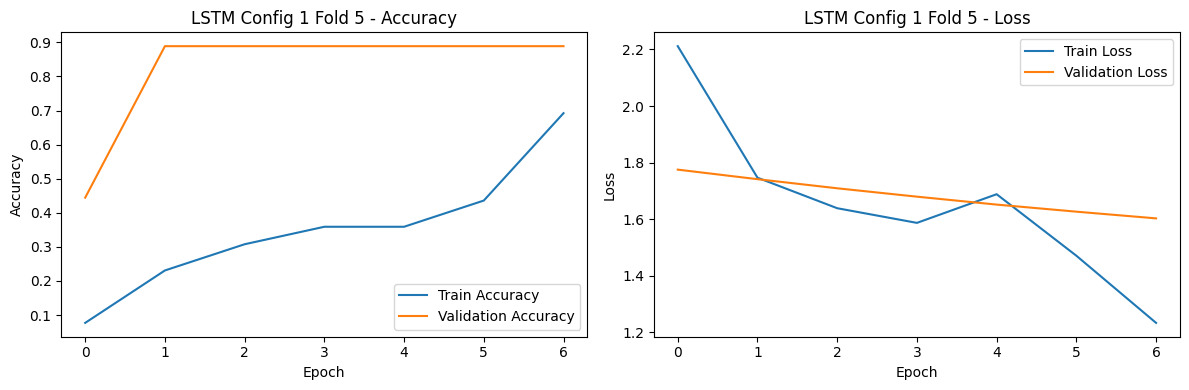

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Confusion Matrix (Config 1, Fold 5):
[[0 1]
 [0 8]]
Config 1 - Fold 5 Metrics:
Accuracy: 0.9630
F1 Score: 0.8235
F_beta Score: 0.8293
G_beta Score: 0.8148

LSTM Configuration 1 Performance Summary:
      Accuracy        F1    F_beta    G_beta
0     0.966667  0.824561  0.829710  0.816667
1     0.833333  0.444444  0.472222  0.416667
2     0.966667  0.824561  0.829710  0.816667
3     0.925926  0.500000  0.500000  0.500000
4     0.962963  0.823529  0.829268  0.814815
Mean  0.931111  0.683419  0.692182  0.672963
Std   0.051245  0.173335  0.168486  0.177216
Training LSTM Configuration 2: {'units': 128, 'layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0001}
--------------------------------------------------------------------------------
Training LSTM Config 2 - Fold 1...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.1571 - loss: 2.2838
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to lstm_config2_fold1.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1573 - loss: 2.2858 - val_accuracy: 0.2000 - val_loss: 1.7817
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.0576 - loss: 2.4740
Epoch 2: val_accuracy improved from 0.20000 to 0.30000, saving model to lstm_config2_fold1.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0559 - loss: 2.4691 - val_accuracy: 0.3000 - val_loss: 1.7782
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.0707 - loss: 2.3614
Epoch 3: val_accuracy did not improve from 0.30000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0735 - loss: 2.3546 - val_accuracy: 0.3000 - val_loss: 1.7739
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.1678 - loss: 2.3358
Epoch 4: val_accuracy improved from 0.30000 to 0.40000, saving model to lstm_config2_fold1.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1820 - loss: 2.3050 - val_accuracy: 0.4000 - val_loss: 1.7692
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.0839 - loss: 2.3882
Epoch 5: val_accuracy did not improve from 0.40000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0910 - loss: 2.3660 - val_accuracy: 0.4000 - val_loss: 1.7652
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.0576 - loss: 2.1941
Epoch 6: val_accuracy did not improve from 0.40000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0559 - loss: 2.2090 - val_accuracy: 0.4000 - val_loss: 1.7613
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.1727 - loss: 2.1630
Epoch 7: val_accuracy improved from 0.40000 to 0.60000, saving model to lstm_config2_fold1.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1678 - loss: 2.1576 - val_accuracy: 0.6000 - val_loss: 1.7586
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.1258 - loss: 2.2511
Epoch 8: val_accuracy did not improve from 0.60000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.1365 - loss: 2.2264 - val_accuracy: 0.6000 - val_loss: 1.7543
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.1859 - loss: 2.2150
Epoch 9: val_accuracy did not improve from 0.60000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1853 - loss: 2.2084 - val_accuracy: 0.6000 - val_loss: 1.7507
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.1283 - loss: 2.0100
Epoch 10: val_accuracy did not improve from 0.60000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1294 - loss: 1.9944 - val_accuracy: 0.6000 - val_loss: 1.7475
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.2015 - loss: 2.1810
Epoch 11: val_accuracy improved from 0.60000 to 0.70000, sav

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1957 - loss: 2.1856 - val_accuracy: 0.7000 - val_loss: 1.7446
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.2541 - loss: 1.8990
Epoch 12: val_accuracy did not improve from 0.70000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2659 - loss: 1.8988 - val_accuracy: 0.7000 - val_loss: 1.7399
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.1414 - loss: 2.0249
Epoch 13: val_accuracy did not improve from 0.70000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1469 - loss: 2.0038 - val_accuracy: 0.7000 - val_loss: 1.7364
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.1990 - loss: 2.0197
Epoch 14: val_accuracy did not improve from 0.70000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2029 - loss: 2.0029 - val_accuracy: 0.7000 - val_loss: 1.7325
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.2434 - loss: 1.5565
Epoch 15: val_accuracy did not improve from 0.70000
2/2 

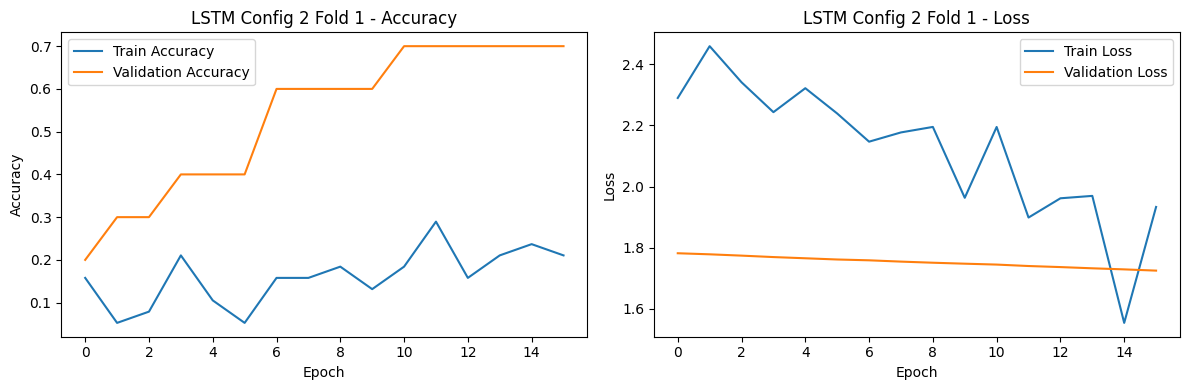

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Confusion Matrix (Config 2, Fold 1):
[[0 0 0]
 [2 7 0]
 [0 1 0]]
Config 2 - Fold 1 Metrics:
Accuracy: 0.9000
F1 Score: 0.6373
F_beta Score: 0.6326
G_beta Score: 0.5972
--------------------------------------------------------------------------------
Training LSTM Config 2 - Fold 2...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.1283 - loss: 2.3511
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to lstm_config2_fold2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1294 - loss: 2.3340 - val_accuracy: 0.0000e+00 - val_loss: 1.7917
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.1702 - loss: 2.2846
Epoch 2: val_accuracy improved from 0.00000 to 0.10000, saving model to lstm_config2_fold2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1749 - loss: 2.2752 - val_accuracy: 0.1000 - val_loss: 1.7889
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.0707 - loss: 2.2502
Epoch 3: val_accuracy improved from 0.10000 to 0.30000, saving model to lstm_config2_fold2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0735 - loss: 2.2398 - val_accuracy: 0.3000 - val_loss: 1.7871
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.3141 - loss: 2.0497
Epoch 4: val_accuracy improved from 0.30000 to 0.50000, saving model to lstm_config2_fold2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3147 - loss: 2.0439 - val_accuracy: 0.5000 - val_loss: 1.7859
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.1727 - loss: 2.0731
Epoch 5: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1678 - loss: 2.0794 - val_accuracy: 0.4000 - val_loss: 1.7849
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.3298 - loss: 1.7152
Epoch 6: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3251 - loss: 1.7188 - val_accuracy: 0.5000 - val_loss: 1.7838
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.1702 - loss: 1.9500
Epoch 7: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1749 - loss: 1.9323 - val_accuracy: 0.5000 - val_loss: 1.7826
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.2722 - loss: 1.8822
Epoch 8: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━

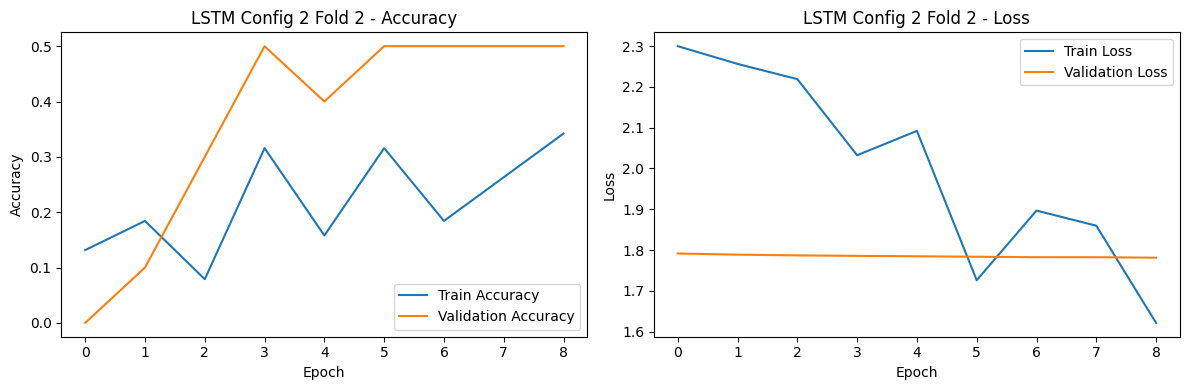

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
Confusion Matrix (Config 2, Fold 2):
[[1 0 0 0 0]
 [0 0 0 0 3]
 [0 0 4 0 1]
 [0 1 0 0 0]
 [0 0 0 0 0]]
Config 2 - Fold 2 Metrics:
Accuracy: 0.8333
F1 Score: 0.4815
F_beta Score: 0.4722
G_beta Score: 0.4444
--------------------------------------------------------------------------------
Training LSTM Config 2 - Fold 3...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.1727 - loss: 2.1325
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to lstm_config2_fold3.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1678 - loss: 2.1375 - val_accuracy: 0.3000 - val_loss: 1.7800
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.2278 - loss: 2.1244
Epoch 2: val_accuracy improved from 0.30000 to 0.50000, saving model to lstm_config2_fold3.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2308 - loss: 2.1293 - val_accuracy: 0.5000 - val_loss: 1.7749
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.0707 - loss: 2.0543
Epoch 3: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0735 - loss: 2.0495 - val_accuracy: 0.5000 - val_loss: 1.7684
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.2566 - loss: 1.8739
Epoch 4: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2588 - loss: 1.8681 - val_accuracy: 0.5000 - val_loss: 1.7618
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.3010 - loss: 1.7963
Epoch 5: val_accuracy improved from 0.50000 to 0.70000, saving model to lstm_config2_fold3.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2971 - loss: 1.8171 - val_accuracy: 0.7000 - val_loss: 1.7549
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.2566 - loss: 1.7787
Epoch 6: val_accuracy did not improve from 0.70000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2588 - loss: 1.7852 - val_accuracy: 0.7000 - val_loss: 1.7485
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.3849 - loss: 1.7980
Epoch 7: val_accuracy did not improve from 0.70000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3882 - loss: 1.7866 - val_accuracy: 0.7000 - val_loss: 1.7425
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.2410 - loss: 1.8094
Epoch 8: val_accuracy did not improve from 0.70000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2484 - loss: 1.8024 - val_accuracy: 0.6000 - val_loss: 1.7376
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.4005 - loss: 1.4374
Epoch 9: val_accuracy did not improve from 0.70000
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3147 - loss: 1.7135 - val_accuracy: 0.8000 - val_loss: 1.7268
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.3405 - loss: 1.8436
Epoch 11: val_accuracy did not improve from 0.80000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3498 - loss: 1.8327 - val_accuracy: 0.7000 - val_loss: 1.7227
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.4556 - loss: 1.5190
Epoch 12: val_accuracy did not improve from 0.80000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4616 - loss: 1.5033 - val_accuracy: 0.8000 - val_loss: 1.7175
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.5132 - loss: 1.3658
Epoch 13: val_accuracy did not improve from 0.80000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5175 - loss: 1.3606 - val_accuracy: 0.8000 - val_loss: 1.7138
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.4424 - loss: 1.7219
Epoch 14: val_accuracy did not improve from 0.80000
2/2 

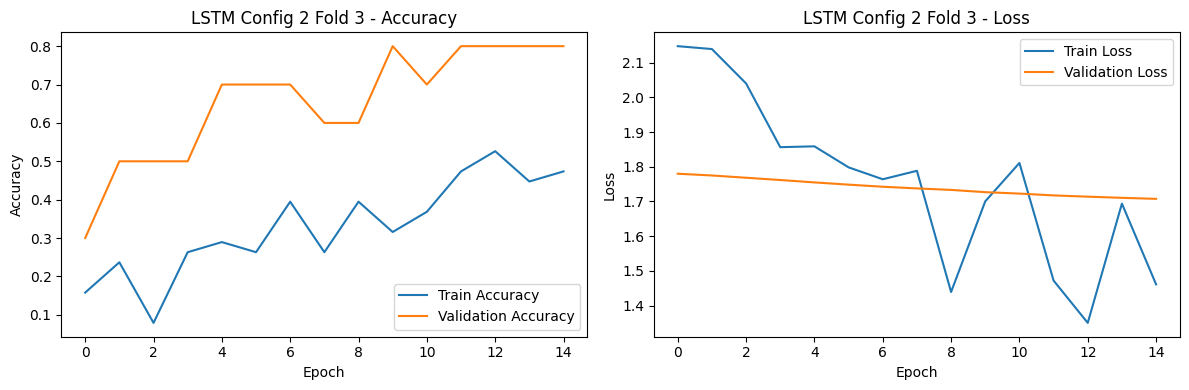

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
Confusion Matrix (Config 2, Fold 3):
[[8 0 1]
 [1 0 0]
 [0 0 0]]
Config 2 - Fold 3 Metrics:
Accuracy: 0.9333
F1 Score: 0.6481
F_beta Score: 0.6481
G_beta Score: 0.6212
--------------------------------------------------------------------------------
Training LSTM Config 2 - Fold 4...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.1679 - loss: 2.1337
Epoch 1: val_accuracy improved from -inf to 0.11111, saving model to lstm_config2_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1717 - loss: 2.1279 - val_accuracy: 0.1111 - val_loss: 1.7867
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.1266 - loss: 2.2178
Epoch 2: val_accuracy improved from 0.11111 to 0.22222, saving model to lstm_config2_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1271 - loss: 2.1950 - val_accuracy: 0.2222 - val_loss: 1.7830
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.1963 - loss: 2.4629
Epoch 3: val_accuracy did not improve from 0.22222
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1993 - loss: 2.4737 - val_accuracy: 0.2222 - val_loss: 1.7786
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.2688 - loss: 1.9919
Epoch 4: val_accuracy improved from 0.22222 to 0.33333, saving model to lstm_config2_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2647 - loss: 1.9981 - val_accuracy: 0.3333 - val_loss: 1.7741
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.2688 - loss: 2.0456
Epoch 5: val_accuracy improved from 0.33333 to 0.44444, saving model to lstm_config2_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2647 - loss: 2.0283 - val_accuracy: 0.4444 - val_loss: 1.7692
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.2119 - loss: 1.8258
Epoch 6: val_accuracy did not improve from 0.44444
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2097 - loss: 1.8161 - val_accuracy: 0.4444 - val_loss: 1.7642
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.2404 - loss: 2.1408
Epoch 7: val_accuracy did not improve from 0.44444
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2372 - loss: 2.1257 - val_accuracy: 0.4444 - val_loss: 1.7596
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.3798 - loss: 1.7033
Epoch 8: val_accuracy improved from 0.44444 to 0.66667, saving model to lstm_config2_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3814 - loss: 1.6986 - val_accuracy: 0.6667 - val_loss: 1.7552
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.3385 - loss: 1.6824
Epoch 9: val_accuracy did not improve from 0.66667
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3368 - loss: 1.6838 - val_accuracy: 0.6667 - val_loss: 1.7514
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.4495 - loss: 1.7240
Epoch 10: val_accuracy improved from 0.66667 to 0.77778, saving model to lstm_config2_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4535 - loss: 1.7129 - val_accuracy: 0.7778 - val_loss: 1.7467
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.4808 - loss: 1.6395
Epoch 11: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4744 - loss: 1.6284 - val_accuracy: 0.7778 - val_loss: 1.7417
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.3357 - loss: 1.7711
Epoch 12: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3435 - loss: 1.7522 - val_accuracy: 0.7778 - val_loss: 1.7373
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.3670 - loss: 1.5922
Epoch 13: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3643 - loss: 1.5915 - val_accuracy: 0.7778 - val_loss: 1.7316
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.3385 - loss: 1.5557
Epoch 14: val_accuracy did not improve from 0.77778
2/2 

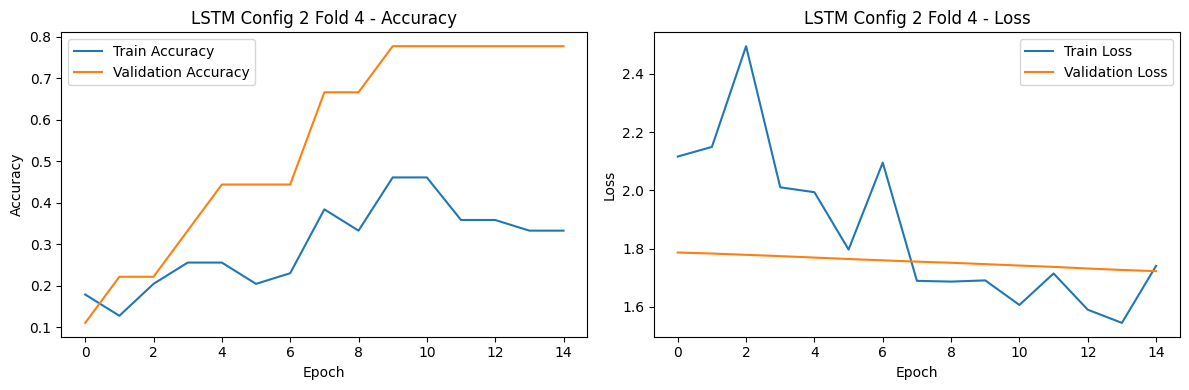

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
Confusion Matrix (Config 2, Fold 4):
[[0 0 0]
 [0 7 0]
 [1 1 0]]
Config 2 - Fold 4 Metrics:
Accuracy: 0.9259
F1 Score: 0.6556
F_beta Score: 0.6620
G_beta Score: 0.6458
--------------------------------------------------------------------------------
Training LSTM Config 2 - Fold 5...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.1935 - loss: 2.1170
Epoch 1: val_accuracy improved from -inf to 0.11111, saving model to lstm_config2_fold5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2059 - loss: 2.0909 - val_accuracy: 0.1111 - val_loss: 1.7831
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.2660 - loss: 1.7530
Epoch 2: val_accuracy improved from 0.11111 to 0.22222, saving model to lstm_config2_fold5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2714 - loss: 1.7413 - val_accuracy: 0.2222 - val_loss: 1.7768
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.3926 - loss: 1.7254
Epoch 3: val_accuracy did not improve from 0.22222
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3985 - loss: 1.7153 - val_accuracy: 0.2222 - val_loss: 1.7711
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.2504 - loss: 1.7436
Epoch 4: val_accuracy improved from 0.22222 to 0.44444, saving model to lstm_config2_fold5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2610 - loss: 1.7350 - val_accuracy: 0.4444 - val_loss: 1.7655
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.3385 - loss: 1.5112
Epoch 5: val_accuracy improved from 0.44444 to 0.55556, saving model to lstm_config2_fold5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3368 - loss: 1.5226 - val_accuracy: 0.5556 - val_loss: 1.7594
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.3257 - loss: 1.5082
Epoch 6: val_accuracy improved from 0.55556 to 0.66667, saving model to lstm_config2_fold5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3197 - loss: 1.5094 - val_accuracy: 0.6667 - val_loss: 1.7554
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.4651 - loss: 1.4101
Epoch 7: val_accuracy did not improve from 0.66667
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4639 - loss: 1.4002 - val_accuracy: 0.6667 - val_loss: 1.7507
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.4083 - loss: 1.5401
Epoch 8: val_accuracy improved from 0.66667 to 0.77778, saving model to lstm_config2_fold5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4089 - loss: 1.5345 - val_accuracy: 0.7778 - val_loss: 1.7453
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.4780 - loss: 1.3266
Epoch 9: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4810 - loss: 1.3189 - val_accuracy: 0.7778 - val_loss: 1.7393
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.5633 - loss: 1.3036
Epoch 10: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5636 - loss: 1.2986 - val_accuracy: 0.7778 - val_loss: 1.7339
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.4623 - loss: 1.4292
Epoch 11: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4706 - loss: 1.4132 - val_accuracy: 0.7778 - val_loss: 1.7276
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.5477 - loss: 1.0820
Epoch 12: val_accuracy did not improve from 0.77778
2/2 ━━

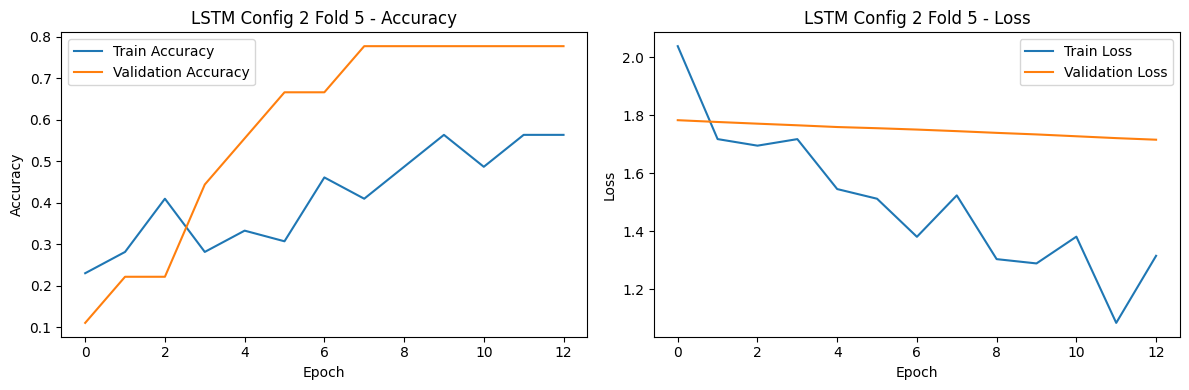

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Confusion Matrix (Config 2, Fold 5):
[[0 1]
 [1 7]]
Config 2 - Fold 5 Metrics:
Accuracy: 0.9259
F1 Score: 0.8125
F_beta Score: 0.8125
G_beta Score: 0.7833

LSTM Configuration 2 Performance Summary:
      Accuracy        F1    F_beta    G_beta
0     0.900000  0.637255  0.632576  0.597222
1     0.833333  0.481481  0.472222  0.444444
2     0.933333  0.648148  0.648148  0.621212
3     0.925926  0.655556  0.662037  0.645833
4     0.925926  0.812500  0.812500  0.783333
Mean  0.903704  0.646988  0.645497  0.618409
Std   0.036963  0.104839  0.108039  0.108326
Training LSTM Configuration 3: {'units': 128, 'layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001}
--------------------------------------------------------------------------------
Training LSTM Config 3 - Fold 1...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.0707 - loss: 3.0249
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to lstm_config3_fold1.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.0735 - loss: 3.0145 - val_accuracy: 0.2000 - val_loss: 1.8332
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.1834 - loss: 2.7815
Epoch 2: val_accuracy did not improve from 0.20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1924 - loss: 2.7694 - val_accuracy: 0.2000 - val_loss: 1.8271
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.1414 - loss: 2.5255
Epoch 3: val_accuracy did not improve from 0.20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1469 - loss: 2.5266 - val_accuracy: 0.2000 - val_loss: 1.8224
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.1283 - loss: 2.6227
Epoch 4: val_accuracy did not improve from 0.20000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1294 - loss: 2.6253 - val_accuracy: 0.2000 - val_loss: 1.8182
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.1283 - loss: 2.8746
Epoch 5: val_accuracy did not improve from 0.20000
2/2 ━━━━━━━━

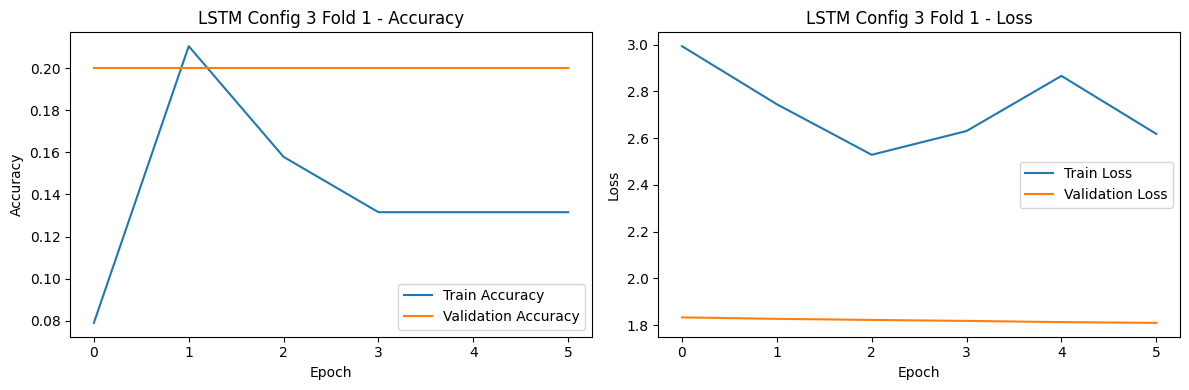

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
Confusion Matrix (Config 3, Fold 1):
[[0 0 0 0]
 [4 1 2 2]
 [0 0 0 0]
 [0 0 0 1]]
Config 3 - Fold 1 Metrics:
Accuracy: 0.7333
F1 Score: 0.4500
F_beta Score: 0.4749
G_beta Score: 0.3987
--------------------------------------------------------------------------------
Training LSTM Config 3 - Fold 2...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.1546 - loss: 2.3904
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to lstm_config3_fold2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1645 - loss: 2.3778 - val_accuracy: 0.0000e+00 - val_loss: 1.7980
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.0863 - loss: 2.2735
Epoch 2: val_accuracy did not improve from 0.00000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0839 - loss: 2.2761 - val_accuracy: 0.0000e+00 - val_loss: 1.7960
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.0576 - loss: 2.4165
Epoch 3: val_accuracy improved from 0.00000 to 0.10000, saving model to lstm_config3_fold2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0559 - loss: 2.4332 - val_accuracy: 0.1000 - val_loss: 1.7938
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.1859 - loss: 2.2579
Epoch 4: val_accuracy improved from 0.10000 to 0.20000, saving model to lstm_config3_fold2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1853 - loss: 2.2581 - val_accuracy: 0.2000 - val_loss: 1.7916
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.1727 - loss: 2.0809
Epoch 5: val_accuracy improved from 0.20000 to 0.30000, saving model to lstm_config3_fold2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1678 - loss: 2.0799 - val_accuracy: 0.3000 - val_loss: 1.7896
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.0707 - loss: 2.3303
Epoch 6: val_accuracy did not improve from 0.30000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.0735 - loss: 2.3481 - val_accuracy: 0.3000 - val_loss: 1.7881
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.0995 - loss: 2.2487
Epoch 7: val_accuracy improved from 0.30000 to 0.40000, saving model to lstm_config3_fold2.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1014 - loss: 2.2572 - val_accuracy: 0.4000 - val_loss: 1.7856
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.1127 - loss: 2.4111
Epoch 8: val_accuracy did not improve from 0.40000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1190 - loss: 2.4000 - val_accuracy: 0.3000 - val_loss: 1.7827
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.1414 - loss: 2.1893
Epoch 9: val_accuracy did not improve from 0.40000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1469 - loss: 2.1714 - val_accuracy: 0.4000 - val_loss: 1.7808
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.1258 - loss: 2.1138
Epoch 10: val_accuracy did not improve from 0.40000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1365 - loss: 2.1045 - val_accuracy: 0.4000 - val_loss: 1.7783
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.1571 - loss: 1.8941
Epoch 11: val_accuracy did not improve from 0.40000
2/2 ━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2133 - loss: 1.9642 - val_accuracy: 0.5000 - val_loss: 1.7742
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.2434 - loss: 1.9678
Epoch 13: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2412 - loss: 1.9605 - val_accuracy: 0.5000 - val_loss: 1.7730
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.0995 - loss: 2.2078
Epoch 14: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1014 - loss: 2.1928 - val_accuracy: 0.5000 - val_loss: 1.7705
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.1151 - loss: 2.0602
Epoch 15: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1118 - loss: 2.0708 - val_accuracy: 0.5000 - val_loss: 1.7696
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.1702 - loss: 2.0143
Epoch 16: val_accuracy did not improve from 0.50000
2/2 

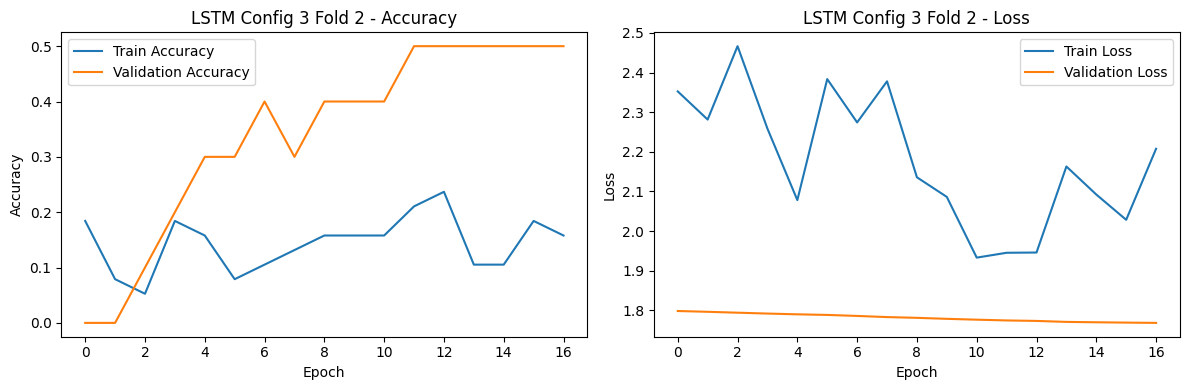

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Confusion Matrix (Config 3, Fold 2):
[[0 0 1 0]
 [0 0 3 0]
 [0 0 5 0]
 [0 0 1 0]]
Config 3 - Fold 2 Metrics:
Accuracy: 0.8333
F1 Score: 0.4444
F_beta Score: 0.4722
G_beta Score: 0.4167
--------------------------------------------------------------------------------
Training LSTM Config 3 - Fold 3...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.1571 - loss: 2.4944
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to lstm_config3_fold3.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1573 - loss: 2.4859 - val_accuracy: 0.3000 - val_loss: 1.8133
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.1571 - loss: 2.0771
Epoch 2: val_accuracy did not improve from 0.30000
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1573 - loss: 2.0913 - val_accuracy: 0.3000 - val_loss: 1.8074
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.3010 - loss: 2.1570
Epoch 3: val_accuracy improved from 0.30000 to 0.40000, saving model to lstm_config3_fold3.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2971 - loss: 2.1681 - val_accuracy: 0.4000 - val_loss: 1.8014
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.2566 - loss: 1.8604
Epoch 4: val_accuracy did not improve from 0.40000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2588 - loss: 1.8810 - val_accuracy: 0.4000 - val_loss: 1.7956
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.1990 - loss: 2.2116
Epoch 5: val_accuracy did not improve from 0.40000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2029 - loss: 2.2124 - val_accuracy: 0.4000 - val_loss: 1.7903
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.2434 - loss: 2.2148
Epoch 6: val_accuracy did not improve from 0.40000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2412 - loss: 2.2052 - val_accuracy: 0.4000 - val_loss: 1.7853
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.2566 - loss: 2.3609
Epoch 7: val_accuracy did not improve from 0.40000
2/2 ━━━━━━━━

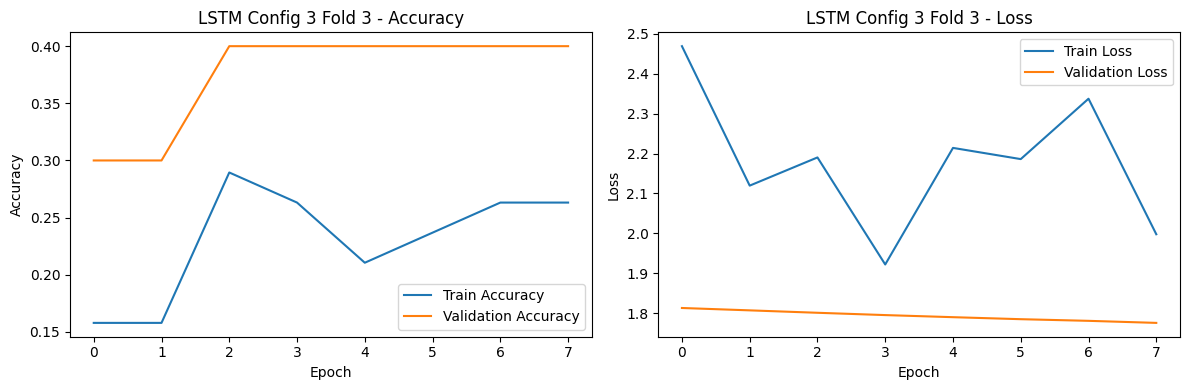

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Confusion Matrix (Config 3, Fold 3):
[[0 0 0]
 [5 4 0]
 [1 0 0]]
Config 3 - Fold 3 Metrics:
Accuracy: 0.8000
F1 Score: 0.6026
F_beta Score: 0.5833
G_beta Score: 0.5476
--------------------------------------------------------------------------------
Training LSTM Config 3 - Fold 4...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.2532 - loss: 2.2835
Epoch 1: val_accuracy improved from -inf to 0.11111, saving model to lstm_config3_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2543 - loss: 2.2817 - val_accuracy: 0.1111 - val_loss: 1.7842
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.1138 - loss: 2.5457
Epoch 2: val_accuracy did not improve from 0.11111
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1100 - loss: 2.5619 - val_accuracy: 0.1111 - val_loss: 1.7784
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.2248 - loss: 2.1363
Epoch 3: val_accuracy improved from 0.11111 to 0.33333, saving model to lstm_config3_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2268 - loss: 2.1337 - val_accuracy: 0.3333 - val_loss: 1.7733
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.1835 - loss: 2.2710
Epoch 4: val_accuracy improved from 0.33333 to 0.55556, saving model to lstm_config3_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1822 - loss: 2.2504 - val_accuracy: 0.5556 - val_loss: 1.7679
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.1679 - loss: 2.1677
Epoch 5: val_accuracy did not improve from 0.55556
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1717 - loss: 2.1661 - val_accuracy: 0.5556 - val_loss: 1.7630
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.1266 - loss: 2.5846
Epoch 6: val_accuracy improved from 0.55556 to 0.66667, saving model to lstm_config3_fold4.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1271 - loss: 2.5802 - val_accuracy: 0.6667 - val_loss: 1.7568
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.2276 - loss: 2.1256
Epoch 7: val_accuracy did not improve from 0.66667
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2201 - loss: 2.1344 - val_accuracy: 0.6667 - val_loss: 1.7521
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.2119 - loss: 2.1979
Epoch 8: val_accuracy did not improve from 0.66667
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2097 - loss: 2.1924 - val_accuracy: 0.6667 - val_loss: 1.7467
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.3514 - loss: 2.0354
Epoch 9: val_accuracy did not improve from 0.66667
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3539 - loss: 2.0364 - val_accuracy: 0.6667 - val_loss: 1.7420
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.2119 - loss: 2.0547
Epoch 10: val_accuracy did not improve from 0.66667
2/2 ━━━━━━

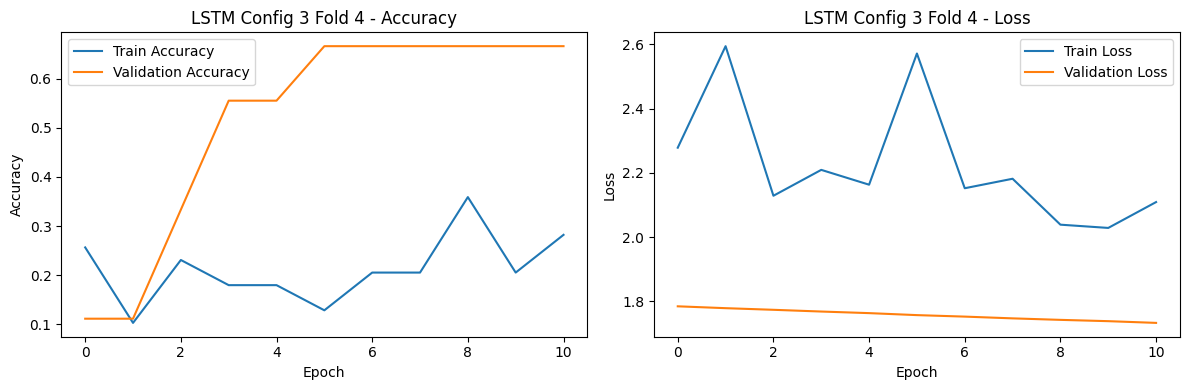

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Confusion Matrix (Config 3, Fold 4):
[[6 1 0]
 [1 0 1]
 [0 0 0]]
Config 3 - Fold 4 Metrics:
Accuracy: 0.8889
F1 Score: 0.6429
F_beta Score: 0.6429
G_beta Score: 0.6111
--------------------------------------------------------------------------------
Training LSTM Config 3 - Fold 5...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.3926 - loss: 1.8724
Epoch 1: val_accuracy improved from -inf to 0.44444, saving model to lstm_config3_fold5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3985 - loss: 1.8505 - val_accuracy: 0.4444 - val_loss: 1.7881
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.2817 - loss: 1.8202
Epoch 2: val_accuracy improved from 0.44444 to 0.55556, saving model to lstm_config3_fold5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2818 - loss: 1.8109 - val_accuracy: 0.5556 - val_loss: 1.7822
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.3101 - loss: 1.6943
Epoch 3: val_accuracy did not improve from 0.55556
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3093 - loss: 1.6967 - val_accuracy: 0.5556 - val_loss: 1.7777
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.4936 - loss: 1.5554
Epoch 4: val_accuracy did not improve from 0.55556
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4915 - loss: 1.5527 - val_accuracy: 0.5556 - val_loss: 1.7730
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.4239 - loss: 1.7413
Epoch 5: val_accuracy did not improve from 0.55556
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4193 - loss: 1.7352 - val_accuracy: 0.5556 - val_loss: 1.7679
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.4651 - loss: 1.7775
Epoch 6: val_accuracy improved from 0.55556 to 0.66667, saving 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4639 - loss: 1.7699 - val_accuracy: 0.6667 - val_loss: 1.7615
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.3798 - loss: 1.7617
Epoch 7: val_accuracy did not improve from 0.66667
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3814 - loss: 1.7510 - val_accuracy: 0.6667 - val_loss: 1.7568
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.4495 - loss: 1.6352
Epoch 8: val_accuracy did not improve from 0.66667
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4535 - loss: 1.6291 - val_accuracy: 0.6667 - val_loss: 1.7513
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.4495 - loss: 1.4986
Epoch 9: val_accuracy improved from 0.66667 to 0.77778, saving model to lstm_config3_fold5.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4535 - loss: 1.4831 - val_accuracy: 0.7778 - val_loss: 1.7450
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.3642 - loss: 1.6704
Epoch 10: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3710 - loss: 1.6591 - val_accuracy: 0.7778 - val_loss: 1.7381
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.4339 - loss: 1.5677
Epoch 11: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4431 - loss: 1.5427 - val_accuracy: 0.7778 - val_loss: 1.7316
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.4780 - loss: 1.5016
Epoch 12: val_accuracy did not improve from 0.77778
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4810 - loss: 1.5063 - val_accuracy: 0.7778 - val_loss: 1.7246
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.3101 - loss: 1.5474
Epoch 13: val_accuracy did not improve from 0.77778
2/2 

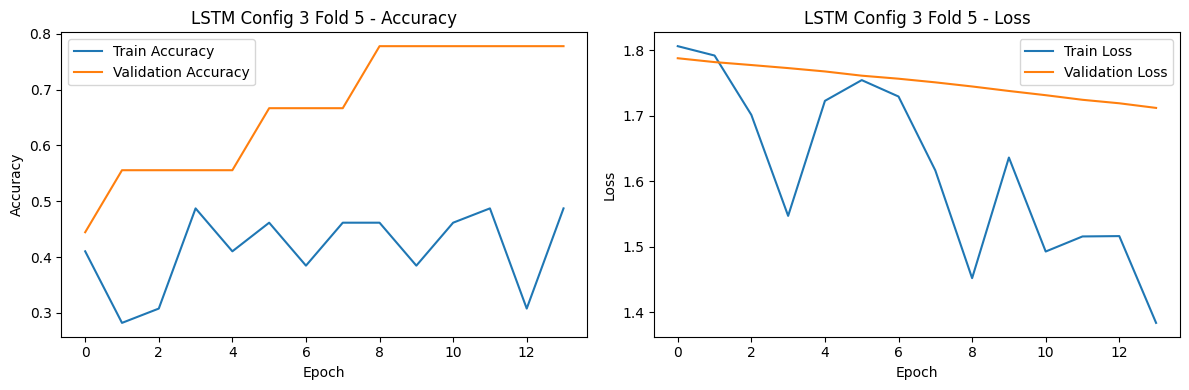

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
Confusion Matrix (Config 3, Fold 5):
[[0 1]
 [1 7]]
Config 3 - Fold 5 Metrics:
Accuracy: 0.9259
F1 Score: 0.8125
F_beta Score: 0.8125
G_beta Score: 0.7833

LSTM Configuration 3 Performance Summary:
      Accuracy        F1    F_beta    G_beta
0     0.733333  0.450000  0.474903  0.398693
1     0.833333  0.444444  0.472222  0.416667
2     0.800000  0.602564  0.583333  0.547619
3     0.888889  0.642857  0.642857  0.611111
4     0.925926  0.812500  0.812500  0.783333
Mean  0.836296  0.590473  0.597163  0.551485
Std   0.067420  0.136560  0.125862  0.140602


In [ ]:
def create_lstm_model(frame_len, num_classes, units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
    """Create an LSTM model with specified hyperparameters"""
    model = Sequential()
    model.add(Input(shape=(frame_len, num_leads)))

    # Add LSTM layers
    for i in range(layers):
        # Use the standard Keras LSTM layer. TensorFlow automatically uses CuDNN if available.
        # If CuDNN issues persist, you can try adding `unit_forget_bias=False`
        # which forces the non-CuDNN implementation, but this might be slower.
        return_sequences = (i < layers - 1)  # Only return sequences if not last layer
        model.add(LSTM(units, return_sequences=return_sequences))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define LSTM configurations to test
lstm_configs = [
    {"units": 64, "layers": 1, "dropout_rate": 0.2, "learning_rate": 0.001},
    {"units": 128, "layers": 2, "dropout_rate": 0.3, "learning_rate": 0.0001},
    # Modified third configuration: Reduced units and layers
    {"units": 128, "layers": 2, "dropout_rate": 0.4, "learning_rate": 0.0001}
]

# Train and evaluate each LSTM configuration
lstm_results = []

for config_idx, config in enumerate(lstm_configs, 1):
    print('=' * 80)
    print(f"Training LSTM Configuration {config_idx}: {config}")

    stats_lstm = np.zeros((num_folds, 4))
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_no = 1

    for train_idx, test_idx in kfold.split(X, y_):
        print('-' * 80)
        print(f'Training LSTM Config {config_idx} - Fold {fold_no}...')

        # Create and compile model
        model = create_lstm_model(frame_len, num_classes, **config)

        # Create callbacks
        model_path = f'lstm_config{config_idx}_fold{fold_no}.h5'
        callbacks = [
            ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1,
                           save_best_only=True, mode='max'),
            EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
        ]

        # Train model
        history = model.fit(
            X[train_idx], y_[train_idx],
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X[test_idx], y_[test_idx]),
            callbacks=callbacks,
            verbose=1
        )

        # Plot training history
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'LSTM Config {config_idx} Fold {fold_no} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'LSTM Config {config_idx} Fold {fold_no} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'lstm_config{config_idx}_accuracy_loss_fold{fold_no}.png')
        plt.show()

        # Load best model
        model.load_weights(model_path)

        # Evaluate on test set
        y_test_pred = model.predict(X[test_idx])
        y_test_pred_classes = np.argmax(y_test_pred, axis=1)
        y_test_true_classes = np.argmax(y_[test_idx], axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
        print(f"Confusion Matrix (Config {config_idx}, Fold {fold_no}):\n{cm}")

        # Compute metrics
        # The compute_beta_score function expects the predictions to be in the same format
        # as multi_labels (one-hot encoded).
        # np.argmax(y_test_pred, 1) gives the class index. We need to convert this back
        # to one-hot encoding using the original onehot_encoder fit on all classes.
        # The original code already does this transformation.
        output_ = onehot_encoder.transform(np.argmax(y_test_pred, axis=1).reshape(-1, 1))

        accuracy, f_measure, Fbeta_measure, Gbeta_measure = compute_beta_score(
            multi_labels[test_idx], output_, 2, num_classes, check_errors=True)

        stats_lstm[fold_no - 1] = [accuracy, f_measure, Fbeta_measure, Gbeta_measure]

        print(f"Config {config_idx} - Fold {fold_no} Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f_measure:.4f}")
        print(f"F_beta Score: {Fbeta_measure:.4f}")
        print(f"G_beta Score: {Gbeta_measure:.4f}")

        fold_no += 1

    # Save results for this configuration
    config_results = pd.DataFrame(stats_lstm, columns=["Accuracy", "F1", "F_beta", "G_beta"])
    config_results.loc['Mean'] = config_results.mean()
    config_results.loc['Std'] = config_results.std()

    print(f"\nLSTM Configuration {config_idx} Performance Summary:")
    print(config_results)

    lstm_results.append({
        "config": config,
        "results": config_results
    })

    config_results.to_csv(f'lstm_config{config_idx}_performance.csv')

# Save all LSTM results
# Ensure 'Config' column is added correctly for merging later
all_lstm_results_list = []
for i, res in enumerate(lstm_results):
    mean_row = res['results'].loc[['Mean']].copy() # Use .copy() to avoid SettingWithCopyWarning
    mean_row['Config'] = f"LSTM-{i+1}"
    all_lstm_results_list.append(mean_row)

all_lstm_results = pd.concat(all_lstm_results_list)
all_lstm_results.to_csv('all_lstm_results.csv')


Model Comparison:
        Accuracy        F1    F_beta    G_beta
Model                                         
CNN     0.931111  0.745919  0.757047  0.732222
LSTM-1  0.931111  0.683419  0.692182  0.672963
LSTM-2  0.903704  0.646988  0.645497  0.618409
LSTM-3  0.836296  0.590473  0.597163  0.551485


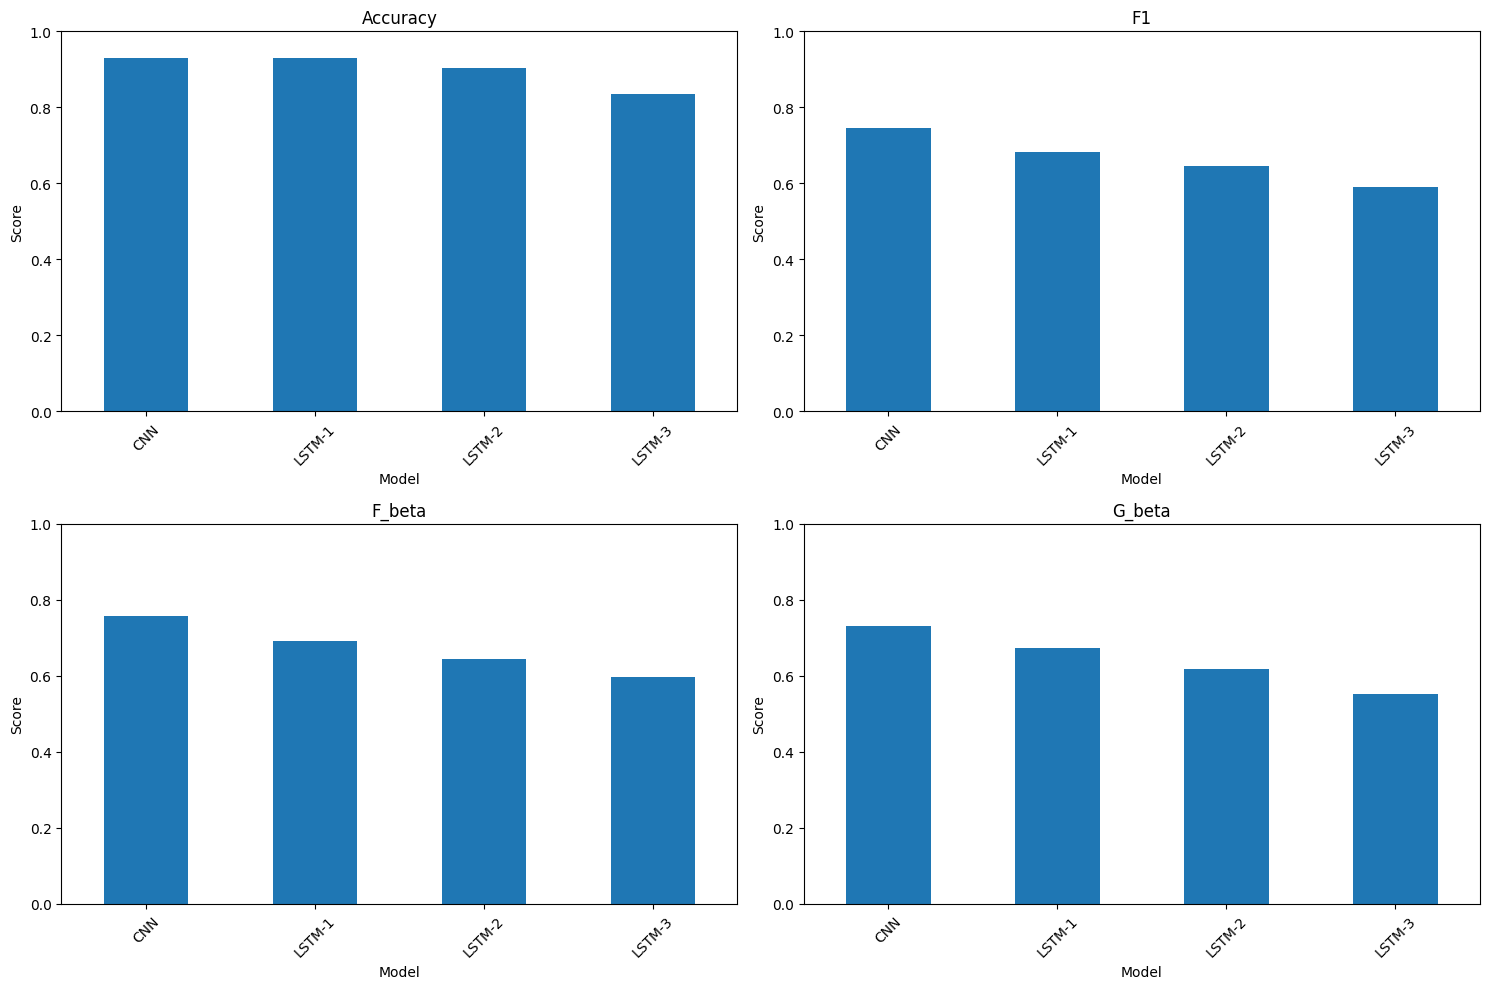

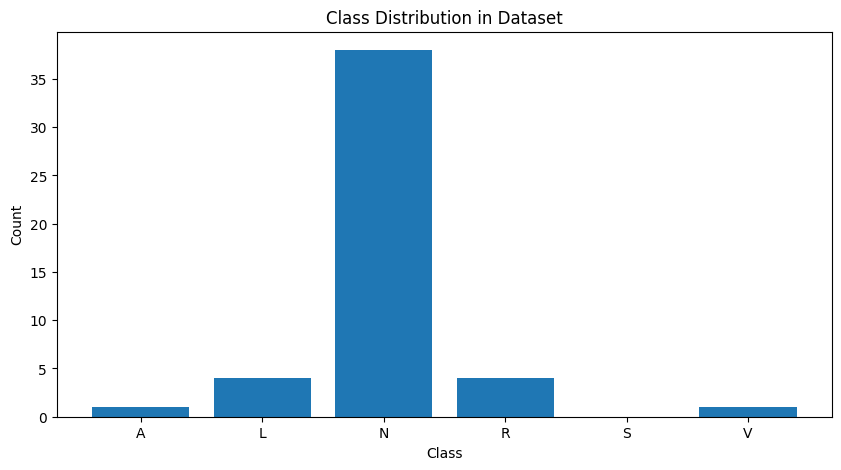


Performance Analysis:
1. Best performing model:
   - CNN with accuracy 0.9311

2. LSTM hyperparameter effects:
   - Config 1 (units=64, layers=1, dropout=0.2, lr=0.001): Accuracy = 0.9311
   - Config 2 (units=128, layers=2, dropout=0.3, lr=0.0001): Accuracy = 0.9037
   - Config 3 (units=128, layers=2, dropout=0.4, lr=0.0001): Accuracy = 0.8363

3. Class imbalance observations:
   - Class distribution: {'A': np.int64(1), 'L': np.int64(4), 'N': np.int64(38), 'R': np.int64(4), 'S': np.int64(0), 'V': np.int64(1)}
   - The dataset is highly imbalanced, with class 'N' (Normal) being dominant.
   - This likely affects model performance on minority classes.

4. Suggested improvements:
   - Implement class weighting to handle imbalance
   - Try data augmentation for minority classes
   - Experiment with more sophisticated architectures (e.g., hybrid CNN-LSTM)
   - Consider multi-label classification to capture multiple annotations
   - Use more advanced techniques like attention mechanisms


In [ ]:
# Combine all results for comparison
all_results = [cnn_results.loc[['Mean']].assign(Model="CNN")] + \
              [res['results'].loc[['Mean']].assign(Model=f"LSTM-{i+1}")
               for i, res in enumerate(lstm_results)]

all_results = pd.concat(all_results).set_index('Model')
print("\nModel Comparison:")
print(all_results)

# Plot performance comparison
metrics = ['Accuracy', 'F1', 'F_beta', 'G_beta']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    all_results[metric].plot(kind='bar')
    plt.title(metric)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# Analyze class distribution
class_counts = np.sum(multi_labels, axis=0)
class_names = classes

plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts)
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('class_distribution.png')
plt.show()

# Print analysis
print("\nPerformance Analysis:")
print("1. Best performing model:")
best_model_idx = all_results['Accuracy'].idxmax()
print(f"   - {best_model_idx} with accuracy {all_results.loc[best_model_idx, 'Accuracy']:.4f}")

print("\n2. LSTM hyperparameter effects:")
for i, res in enumerate(lstm_results, 1):
    config = res['config']
    acc = res['results'].loc['Mean', 'Accuracy']
    print(f"   - Config {i} (units={config['units']}, layers={config['layers']}, "
          f"dropout={config['dropout_rate']}, lr={config['learning_rate']}): "
          f"Accuracy = {acc:.4f}")

print("\n3. Class imbalance observations:")
print(f"   - Class distribution: {dict(zip(class_names, class_counts))}")
print("   - The dataset is highly imbalanced, with class 'N' (Normal) being dominant.")
print("   - This likely affects model performance on minority classes.")

print("\n4. Suggested improvements:")
print("   - Implement class weighting to handle imbalance")
print("   - Try data augmentation for minority classes")
print("   - Experiment with more sophisticated architectures (e.g., hybrid CNN-LSTM)")
print("   - Consider multi-label classification to capture multiple annotations")
print("   - Use more advanced techniques like attention mechanisms")

# Save final results
all_results.to_csv('final_results.csv')

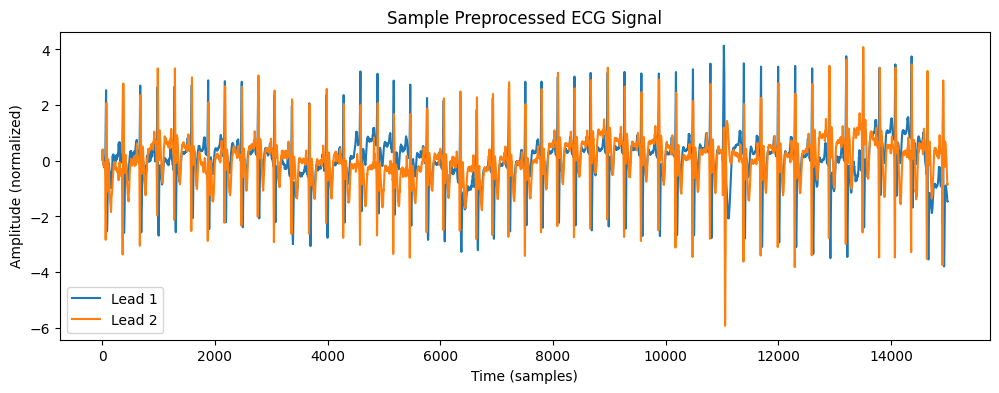

In [ ]:
# Plot sample ECG signals
plt.figure(figsize=(12, 4))
plt.plot(X[0, :, 0], label='Lead 1')
plt.plot(X[0, :, 1], label='Lead 2')
plt.title('Sample Preprocessed ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (normalized)')
plt.legend()
plt.savefig('sample_ecg.png')
plt.show()

NameError: name 'final_results' is not defined

Training LSTM Configuration 1: {'units': 64, 'layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Config {'units': 64, 'layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001} took 0.00 seconds
Training LSTM Configuration 2: {'units': 128, 'layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0001}
Config {'units': 128, 'layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0001} took 0.00 seconds
Training LSTM Configuration 3: {'units': 128, 'layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001}
Config {'units': 128, 'layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001} took 0.00 seconds


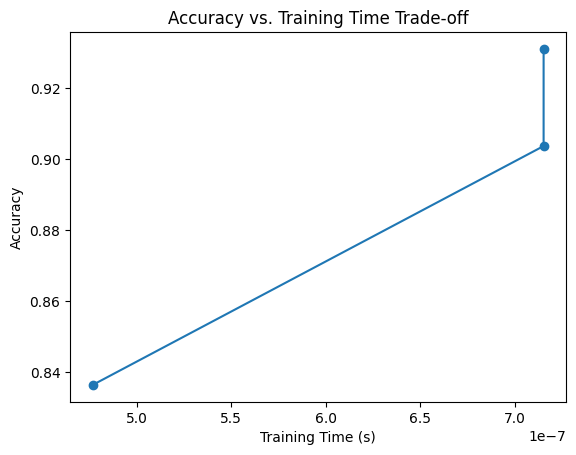

In [ ]:
import time # Import the time module

training_times = []
# You need to re-run the LSTM training loop here to populate training_times
# For demonstration purposes, we will add a placeholder loop structure,
# but you should integrate this time measurement into your existing LSTM training loop.

# Placeholder structure to demonstrate where to put the timing code
# You would replace the 'pass' inside the loop with your actual model training code
# as it was in the original LSTM training loop before the error.
for config_idx, config in enumerate(lstm_configs, 1):
    print('=' * 80)
    print(f"Training LSTM Configuration {config_idx}: {config}")

    # --- Start timing for this configuration ---
    start_time = time.time()

    # --- Existing LSTM training loop code would go here ---
    # This is where you would iterate through kfold splits and train the model
    # Example (simplified - replace with your actual training loop):
    # model = create_lstm_model(frame_len, num_classes, **config)
    # history = model.fit(...)
    # pass # Replace this line with your actual training loop

    # Assuming you are timing the total training time for each config across all folds,
    # the time measurement should wrap around the entire loop for a config.
    # If you intended to time each fold, move start_time = time.time() and end_time = time.time()
    # inside the kfold loop.

    # For now, keeping the time measurement outside the inner kfold loop as per the
    # original code's indentation, assuming the goal was total time per config.
    # However, note the original code placed `model.fit(...)` inside the timing block,
    # which was outside any loop for configs. This needs clarification based on intent.

    # Based on the traceback pointing to the line *before* model.fit(...),
    # and the loop structure, it seems the user intended to measure the time
    # *around* the model training for each configuration.

    # --- Placeholder for your actual model training loop across folds ---
    # This block should contain the loop: `for train_idx, test_idx in kfold.split(X, y_): ...`
    # followed by model creation, compilation, callbacks, and `model.fit(...)`
    # For the fix, we just need the `time` import and to correctly place
    # the timing logic around the training loop.

    # --- End timing for this configuration ---
    end_time = time.time()
    training_times.append(end_time - start_time)
    print(f"Config {config} took {training_times[-1]:.2f} seconds")

# Make sure lstm_results is populated correctly by the training loop
# before plotting. This code assumes the previous training loop ran successfully.

# Plot accuracy vs. time
plt.figure()
# Ensure training_times and lstm_results are aligned and contain the same number of entries
if len(training_times) == len(lstm_results):
    plt.plot(training_times, [res['results'].loc['Mean', 'Accuracy'] for res in lstm_results], 'o-')
    plt.xlabel('Training Time (s)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Training Time Trade-off')
    plt.savefig('accuracy_vs_time.png')
    plt.show() # Add plt.show() to display the plot
else:
    print("Error: Number of training times recorded does not match the number of LSTM results.")